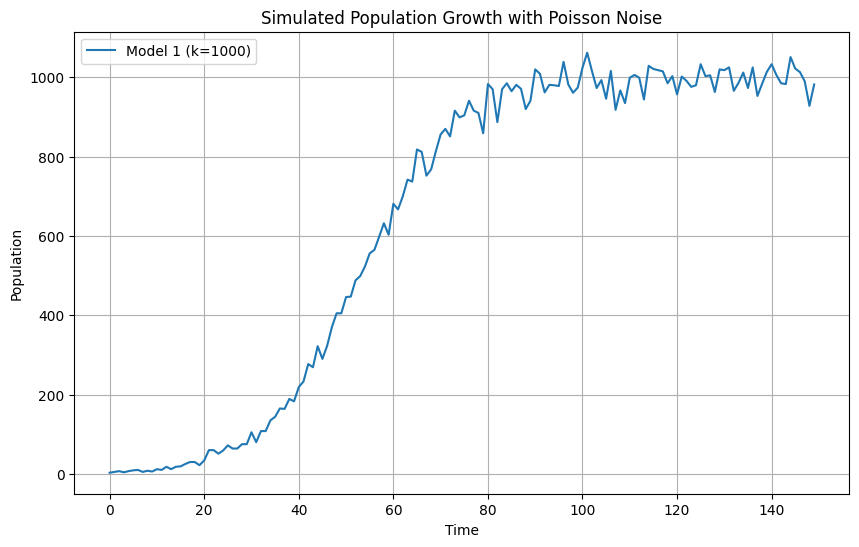

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd

def growthEQ(t, y):
    r = 0.1
    return r*y*(1 - (y/carrying_cap))

num_of_models = 1
time = 150
states = [5]
k_vals = [1000]
data = np.empty([1, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=growthEQ, 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i,:] = np.random.poisson(sol.y[0])

# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

## Increasing the rate

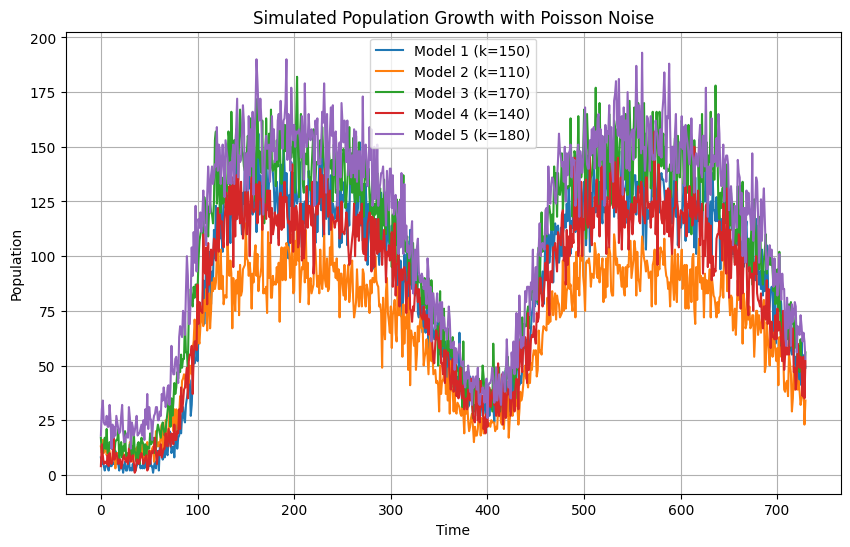

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd


d=365
t=np.linspace(0,2*d,2*d+1)
def effBeta(t):
    return 0.1*(1.2-np.cos(t/d*2*np.pi))

mu = 0.03


def growthEQ(t, y,i):
    r = effBeta(t)
    return r*y*(1 - (y/carrying_cap)) - mu*y

num_of_models = 5
time = 730
states = [5, 12, 15, 8, 27]
k_vals = [150, 110, 170, 140, 180]
data = np.empty([num_of_models, time])


for i in range(num_of_models):
    if len(states) != num_of_models or len(k_vals) != num_of_models:
        print("Either initial states or k_vals does not equal the number of models.")
        exit()

    init_state = [states[i]]
    carrying_cap = k_vals[i]
    sol = solve_ivp(fun=lambda t, y: growthEQ(t,y,i), 
                    t_span=[0, time], 
                    y0=init_state, 
                    t_eval=range(time))
    data[i] = np.random.poisson(sol.y[0])


# Save to CSV
file_path = '../datasets/resample_experiment_time_series.csv'
df = pd.DataFrame(data.T, columns=[f'Model {i+1} (k={k})' for i, k in enumerate(k_vals)])
df.to_csv(file_path, index=False)


# Create plot for data 
plt.figure(figsize=(10, 6))
for i in range(num_of_models):
    plt.plot(np.arange(time), data[i], label=f'Model {i+1} (k={k_vals[i]})')

plt.title('Simulated Population Growth with Poisson Noise')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
'''Entry point for the particle filtering code '''

import sys
sys.path.append('../')
import numpy as np

from Implementations.algorithms.TimeDependentBeta import TimeDependentAlgo
from Implementations.algorithms.Experiment import ExperimentAlgo
from Implementations.resamplers.resamplers import PoissonResample, LogNBinomResampleExperiment,PoissonResampleExperiment
from Implementations.solvers.DeterministicSolvers import LSODACalvettiSolver,LSODASolverExperimentLogistic,LSODASolverSEIARHD, EulerSolverExperiment
from Implementations.perturbers.perturbers import LogMultivariatePerturbations, ExperimentPerturb,LinExperimentPerturb
from utilities.Utils import Context,ESTIMATION
from utilities.sankey import visualize_particles
from functools import partial


'''Algorithm object encapsulating all the requirements

The integrator is an object which runs the t->t+1 propagation of the particles, primarily using the LSODA 
integrator built in to scipy.integrate(solve_ivp)

The perturb object performs multivariate perturbations on the state variables and the estimated variables

The resampler computes the weights and resamples based on a known algorithm(multinomial,systematic,residual)



'''
algo = ExperimentAlgo(integrator = LSODASolverExperimentLogistic(),
                        perturb = ExperimentPerturb(hyper_params={'sigma':0.05,'h':0.01}),
                        resampler = LogNBinomResampleExperiment(),
                        ctx=Context(population=30,
                                    state_size = 5,
                                    weights=np.zeros(1000),
                                    seed_loc=[0,1,2,3,4],
                                    seed_size=100,
                                    forward_estimation=1,
                                    rng=np.random.default_rng(),
                                    particle_count=1000,
                                    run_sankey=True)
                                    )

algo.initialize(params={
"r": ESTIMATION.VARIABLE,
"k": ESTIMATION.STATIC_PER_LOCATION,
"mu": 0.03,
"R": 50
}
,priors={
"r": partial(algo.ctx.rng.uniform, 0.0, 0.15),
"k": partial(algo.ctx.rng.multivariate_normal, [100,100,100,100,100],25*np.eye(5)),
"mu": partial(algo.ctx.rng.uniform, 0.02, 0.07),
"R":partial(algo.ctx.rng.uniform, 10, 50)
})

# '''Runs the PF over the specified data set for the specified length of time'''
# for particle in algo.particles:
#     particle.param["k"] = np.array([150, 110, 170, 140, 180])

#algo.print_particles()

algo.run(f'../datasets/resample_experiment_time_series.csv',100)




Iteration: 0
r: 0.076298910767874
k: [106.62272984  98.64136819 101.25483727  99.89627702  93.41290715]
mu: 0.03
Iteration: 1
r: 0.08153989727271126
k: [115.64547625 106.83105837 109.71792811 108.21705129 101.06041129]
mu: 0.03
Iteration: 2
r: 0.12146911047323274
k: [145.33806297 134.229645   137.9191896  136.00665045 126.75634018]
mu: 0.03
Iteration: 3
r: 0.23249356260638565
k: [177.79008182 170.27450238 173.07929235 171.69328363 163.53411824]
mu: 0.03
Iteration: 4
r: 0.28096494186721
k: [180.38558449 176.28605947 177.89001784 177.11480329 171.78419404]
mu: 0.03
Iteration: 5
r: 0.34251977272246853
k: [183.25920092 181.80841706 182.43030303 182.145713   179.55039394]
mu: 0.029999999999999995
Iteration: 6
r: 0.30330515221306314
k: [175.1000065  173.96221961 174.45377079 174.22677754 172.13543582]
mu: 0.030000000000000002
Iteration: 7
r: 0.289041277262785
k: [168.2253383  167.5538951  167.86938381 167.7256815  166.36188434]
mu: 0.030000000000000002
Iteration: 8
r: 0.26394087646810666
k: 

In [7]:
visualize_particles(100,algo.ctx.sankey_indices)

ValueError: could not broadcast input array from shape (100,) into shape (1000,)

<Figure size 4800x3000 with 0 Axes>

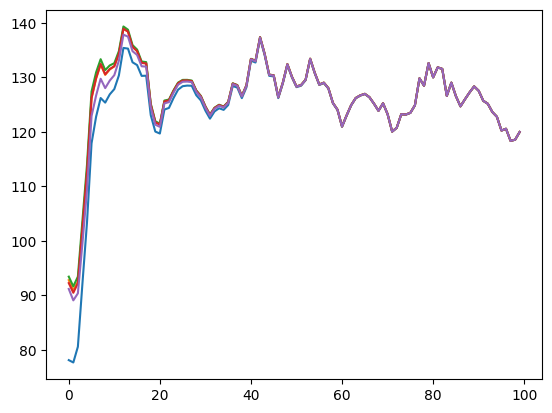

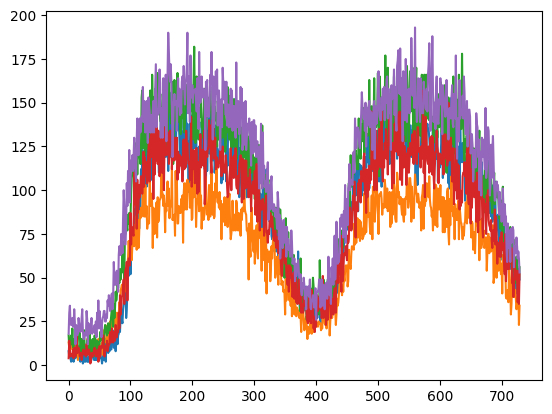

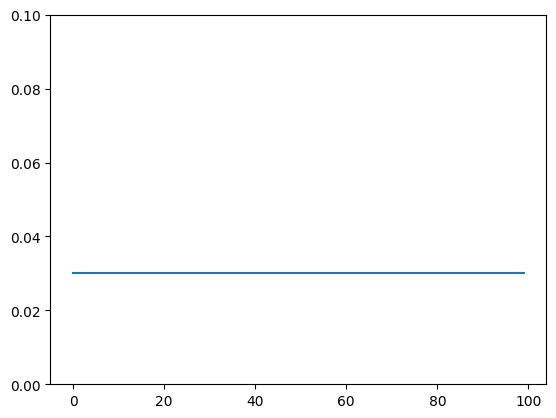

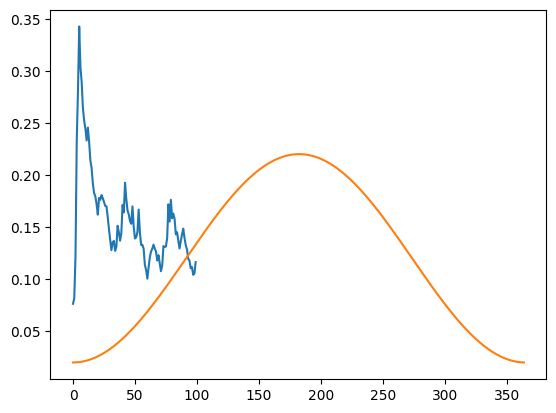

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

pf_state = pd.read_csv('../datasets/state_quantiles.csv').to_numpy()
pf_state = np.delete(pf_state,0,1)
pf_r = pd.read_csv('../datasets/r_quantiles.csv').to_numpy()
pf_r = np.delete(pf_r,0,1)
pf_mu = pd.read_csv('../datasets/mu_quantiles.csv').to_numpy()
pf_mu = np.delete(pf_mu,0,1)


real_data = pd.read_csv('../datasets/resample_experiment_time_series.csv').to_numpy()
#real_data = np.delete(real_data,0,1)



d=365
t=np.linspace(0,2*d,2*d+1)
def effBeta(t):
    return 0.1*(1.2-np.cos(t/d*2*np.pi))

r_vals = [effBeta(t) for t in range(365)]

plt.plot(pf_state)
plt.show()
plt.plot(real_data)
plt.show()

plt.plot(pf_mu)
plt.ylim(0,0.1)
plt.show()

plt.plot(pf_r)
plt.plot(r_vals)
plt.show()